In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv("HOME")+'/aiffel/kaggle_kakr_housing/data/'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print(f'train data dim : {data.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


In [5]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
train_len = len(data)
print(len(data))

15035


Features  
ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 집의 가격(Target variable)  
bedrooms : 침실의 수  
bathrooms : 화장실의 수  
sqft_living : 주거 공간의 평방 피트(면적)  
sqft_lot : 부지의 평방 피트(면적)  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트(면적)  
sqft_basement : 지하실의 평방 피트(면적)  
yr_built : 지어진 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [7]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

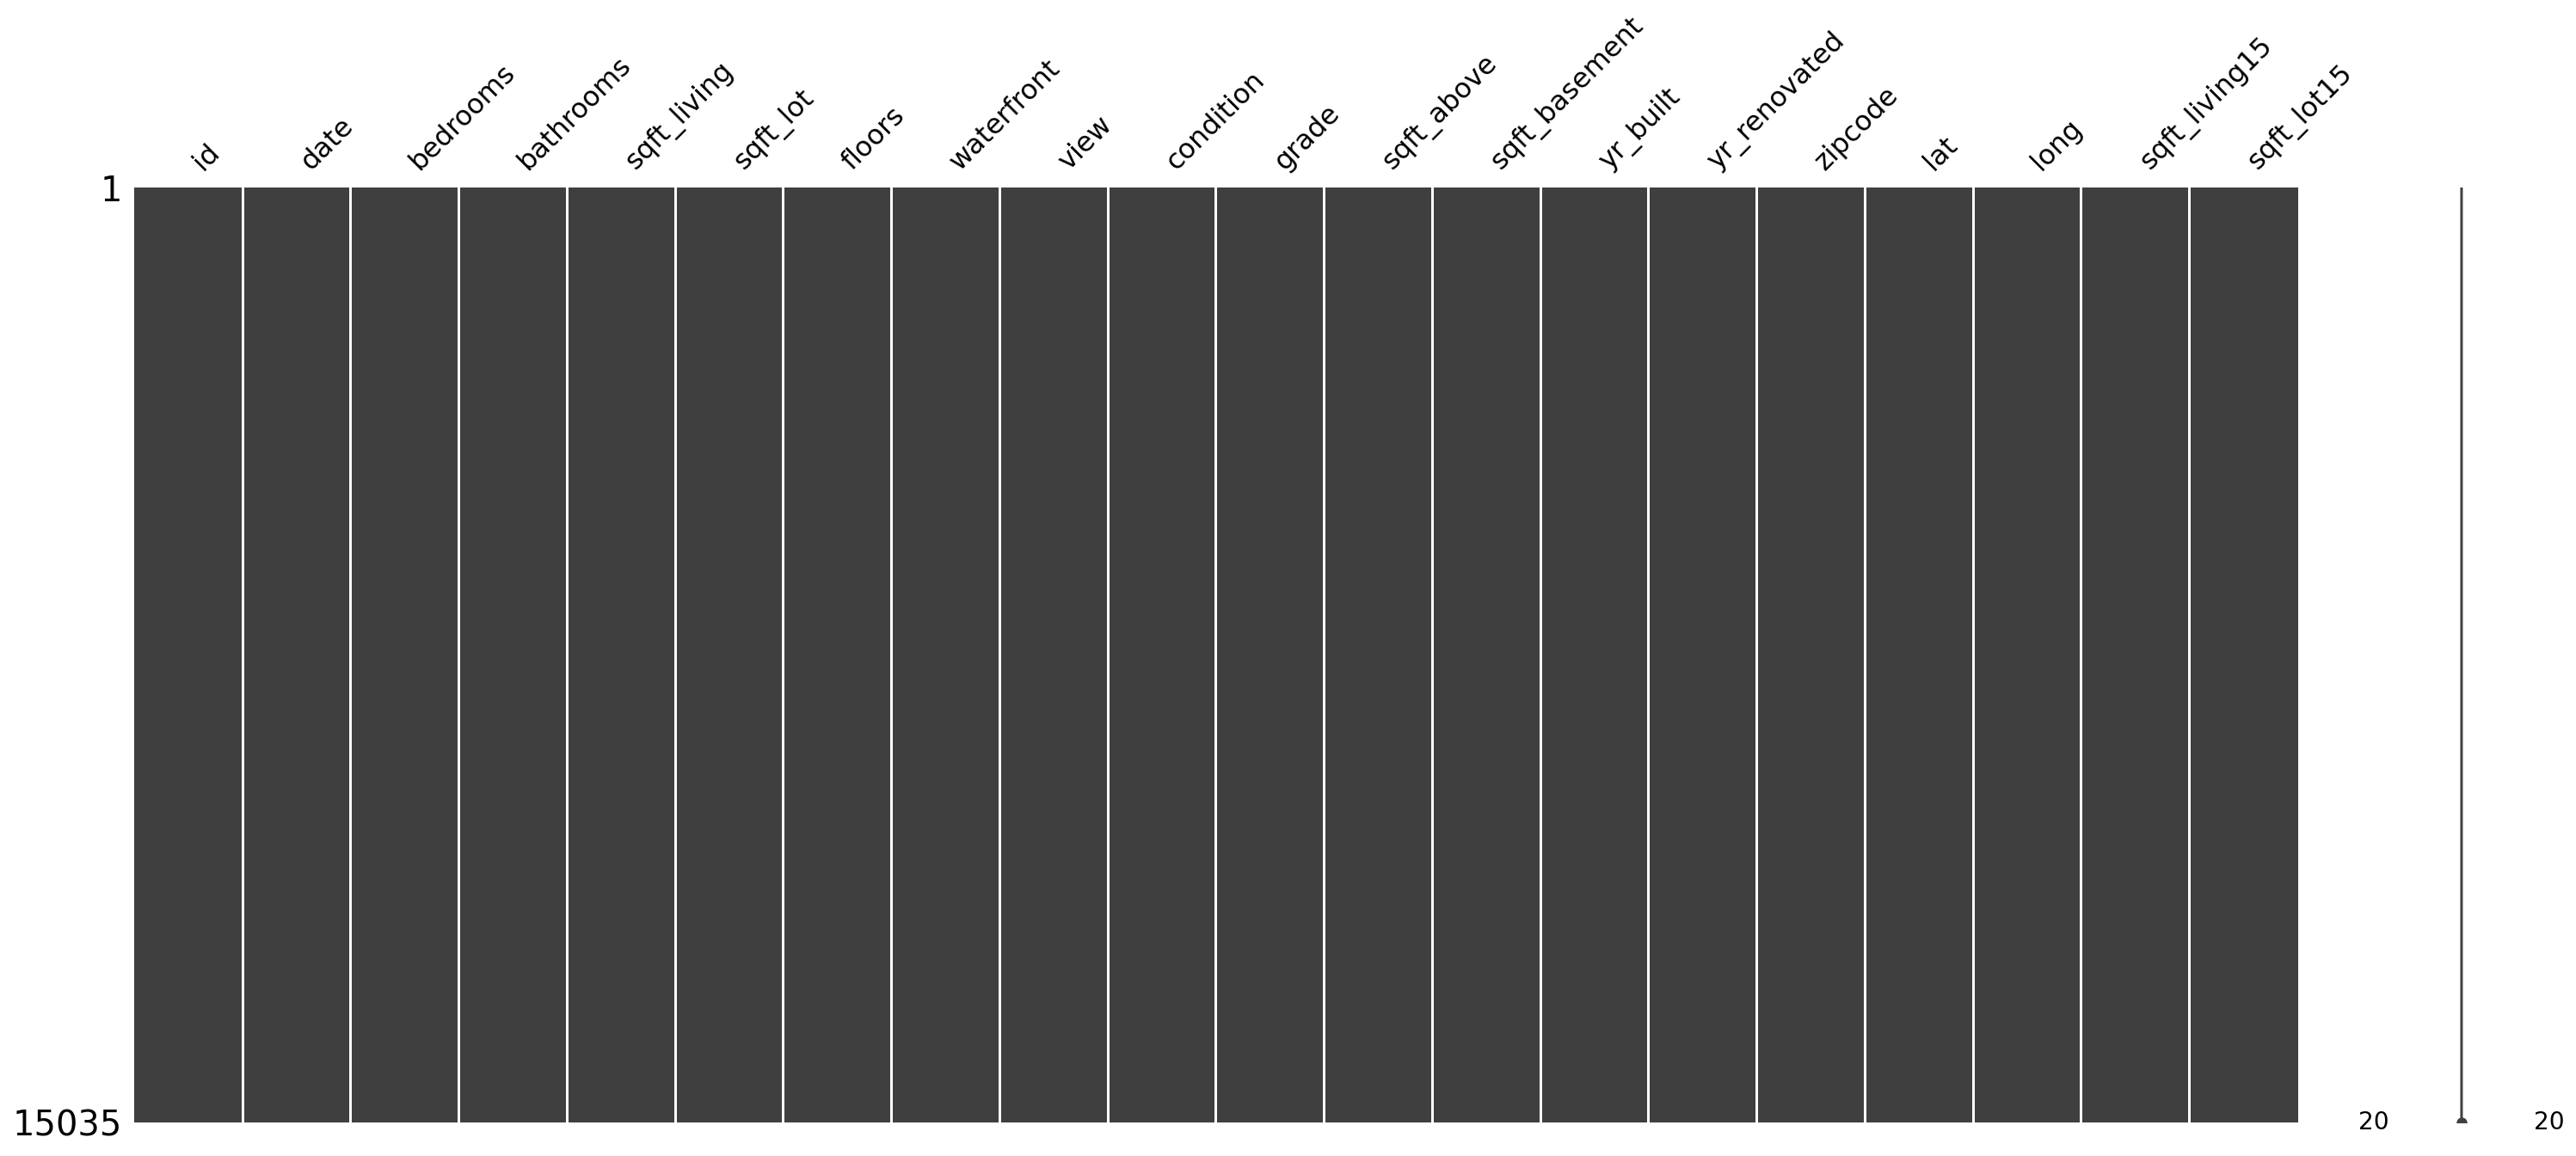

In [8]:
msno.matrix(data)

In [9]:
test_len = len(test)
print(len(test))

6468


In [10]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


<AxesSubplot:>

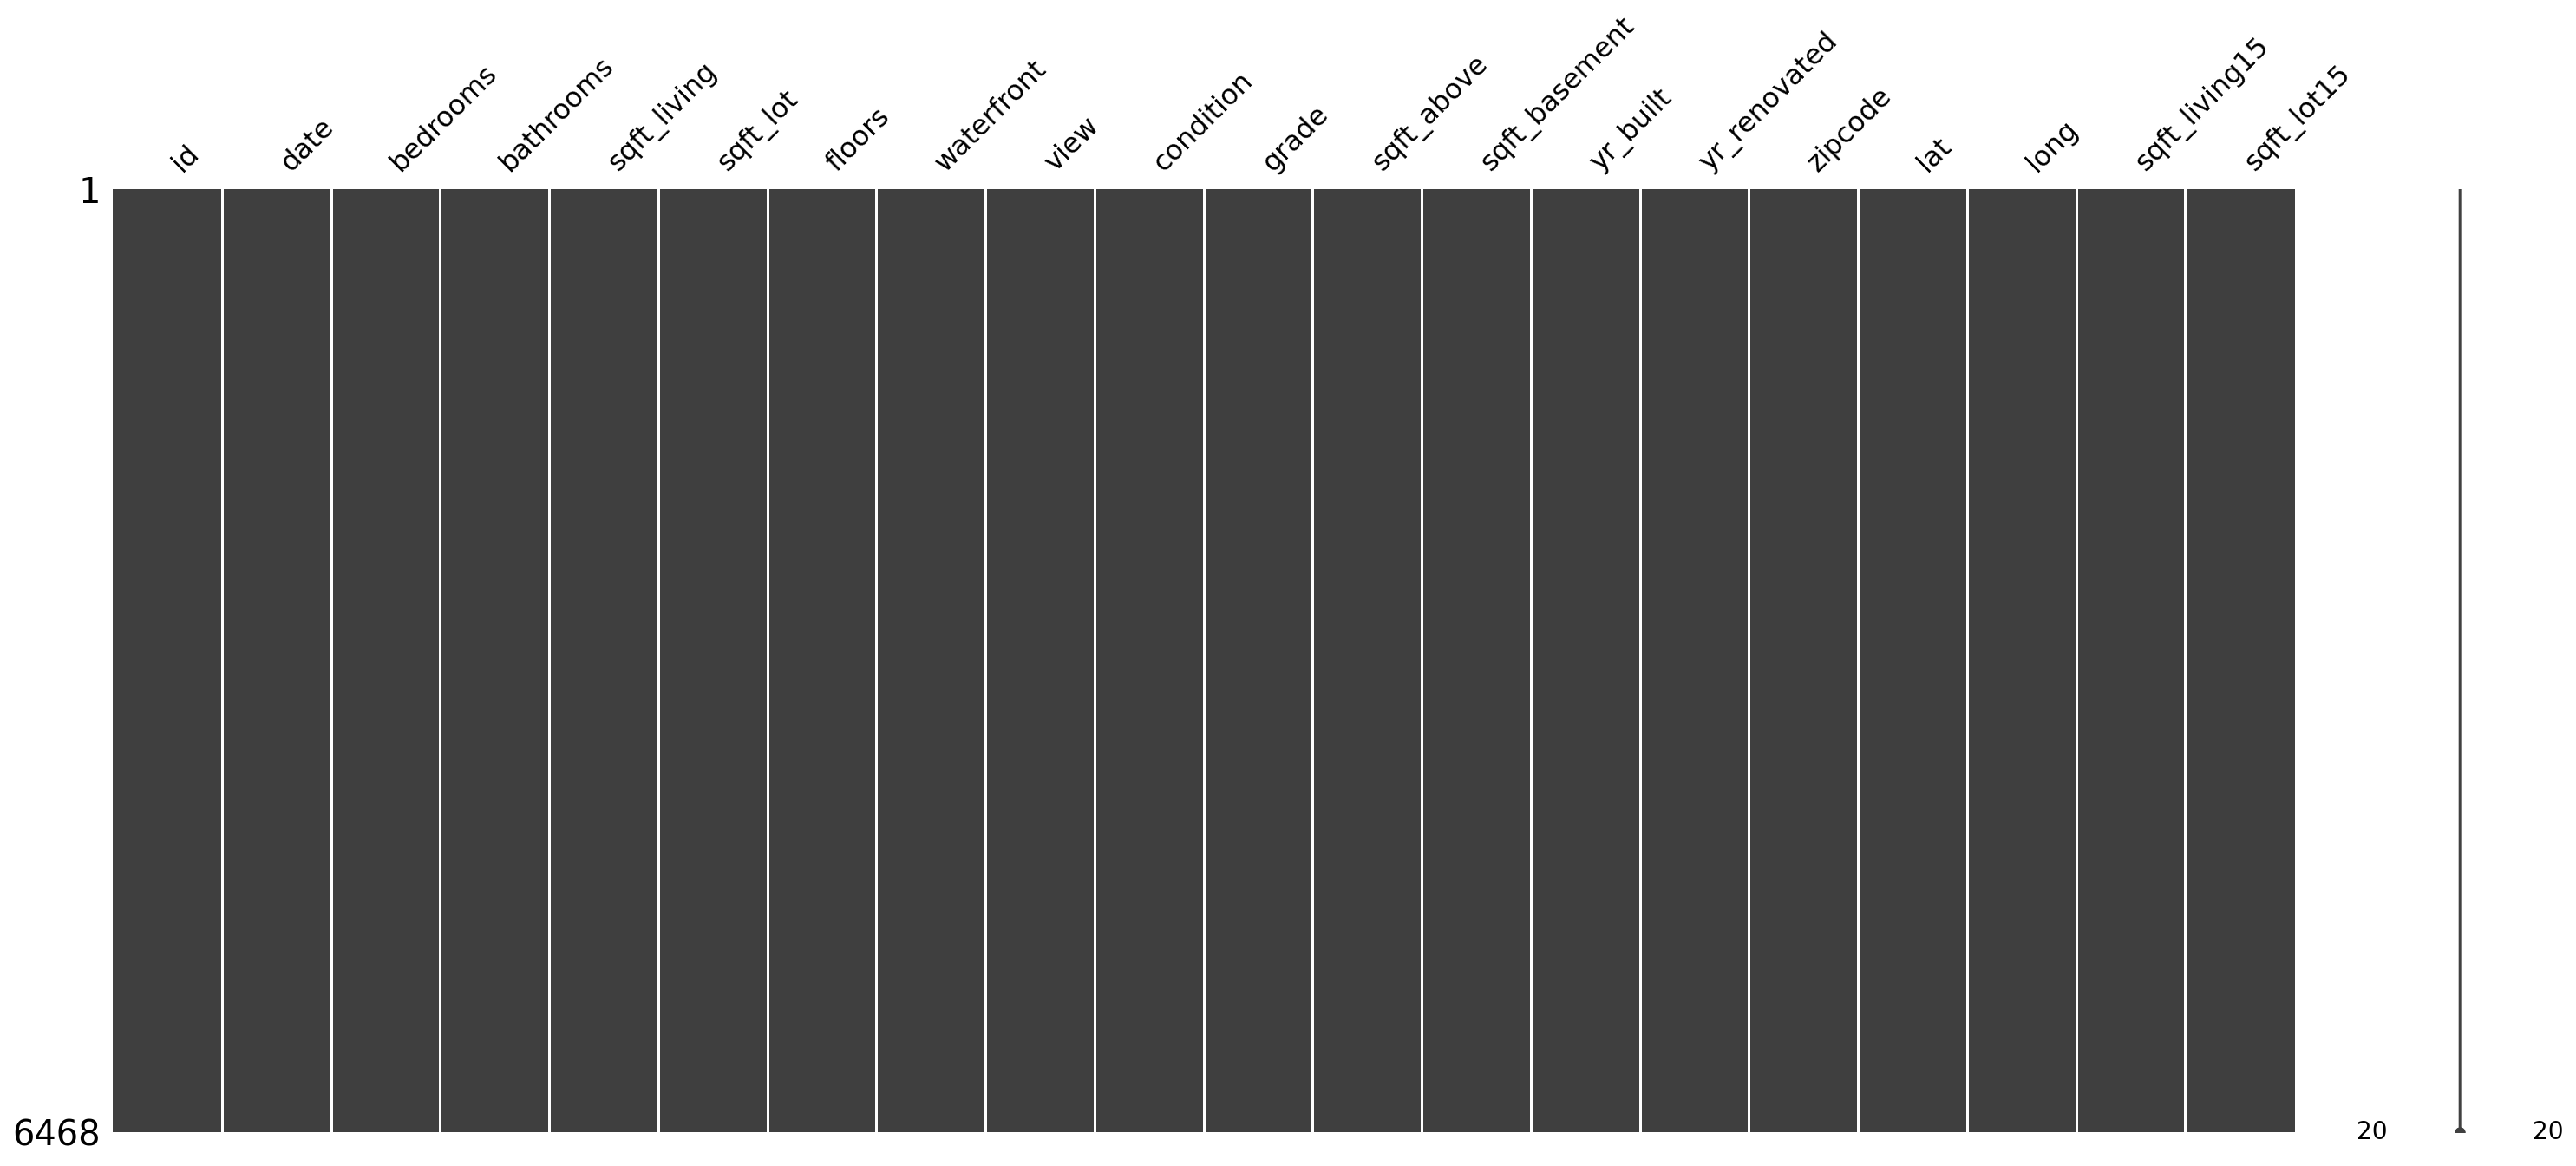

In [11]:
msno.matrix(test)

In [12]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0        False
1        False
2        False
3        False
4        False
         ...  
15030    False
15031    False
15032    False
15033    False
15034    False
Name: id, Length: 15035, dtype: bool


In [13]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [14]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [15]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [16]:
data_id = data['id'][train_len:]
del data['id']

sub_id = test['id'][test_len:]
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [17]:
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [18]:
data['year'] = data['date'].apply(lambda i: i[:4]).astype(int)
data['month'] = data['date'].apply(lambda i: i[4:6]).astype(int)
data.drop(columns=['date'], inplace=True)
data.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,2014,6
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,2015,1


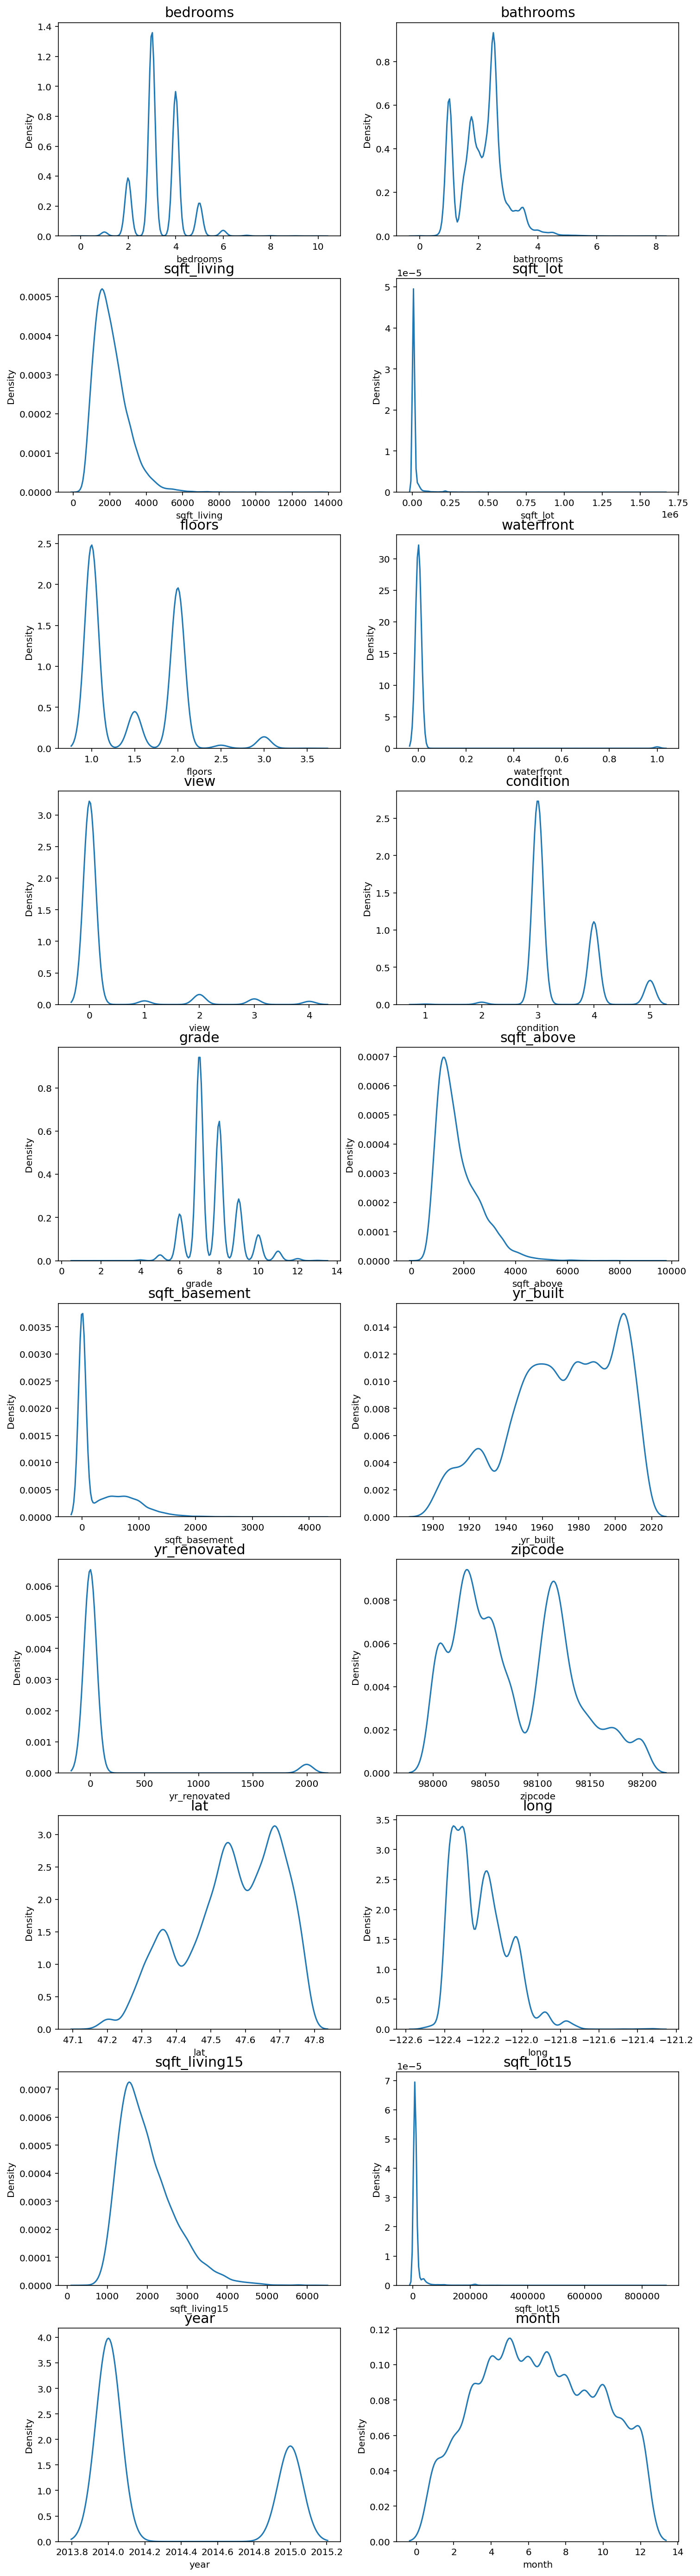

In [19]:
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 20 :
            break

In [20]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

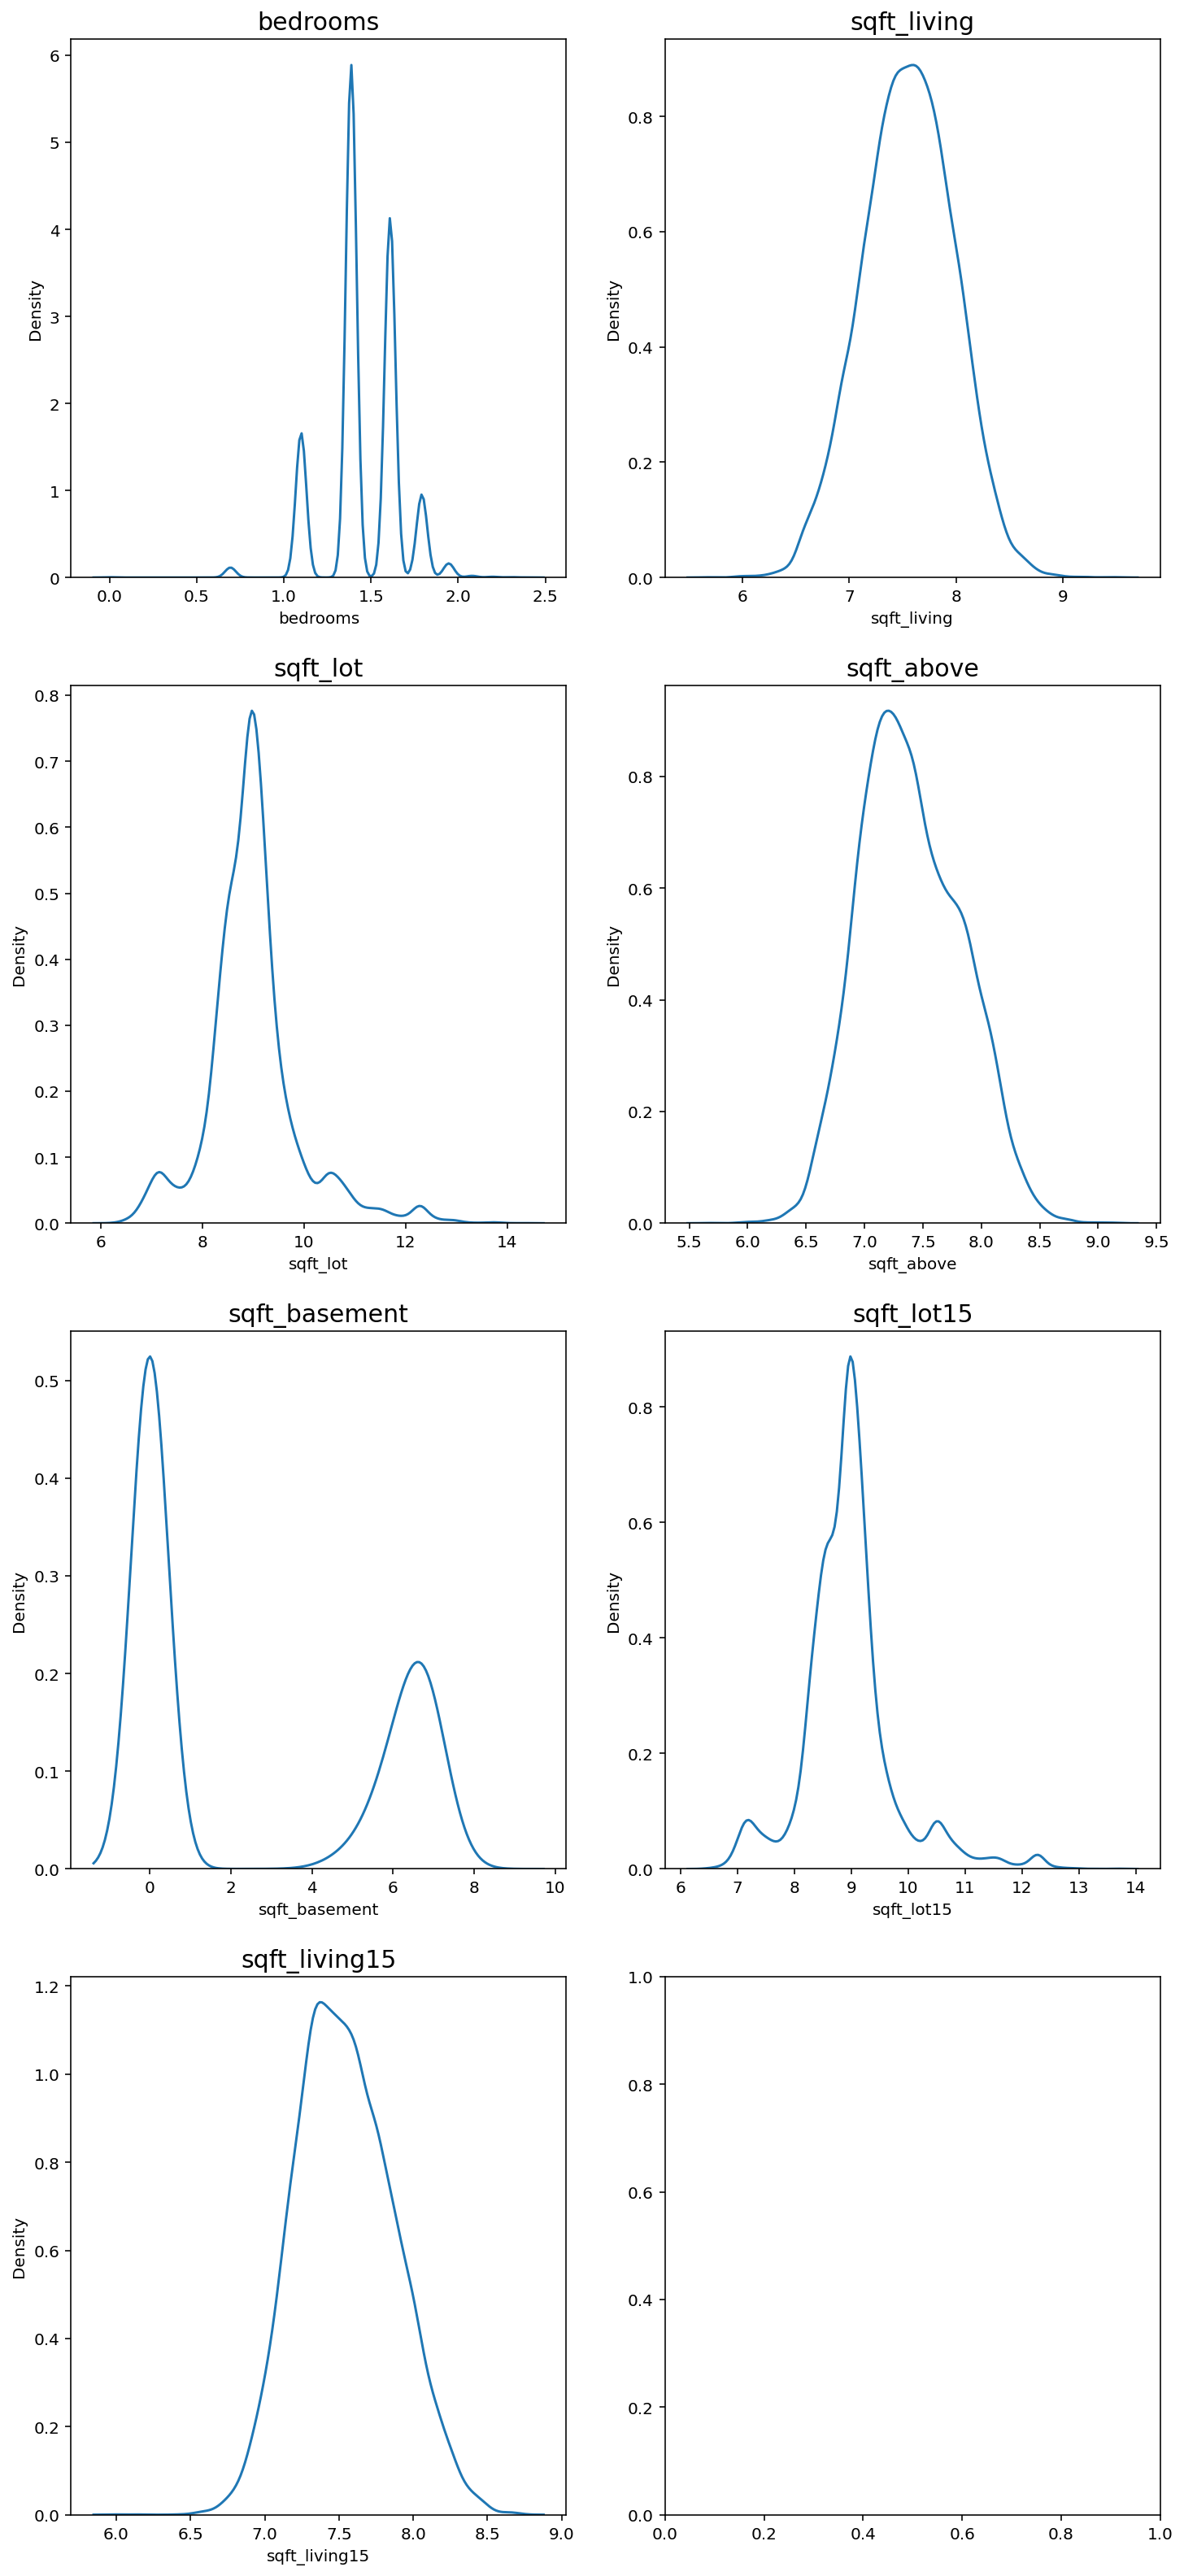

In [21]:
fig, ax = plt.subplots(4, 2, figsize=(12, 28))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

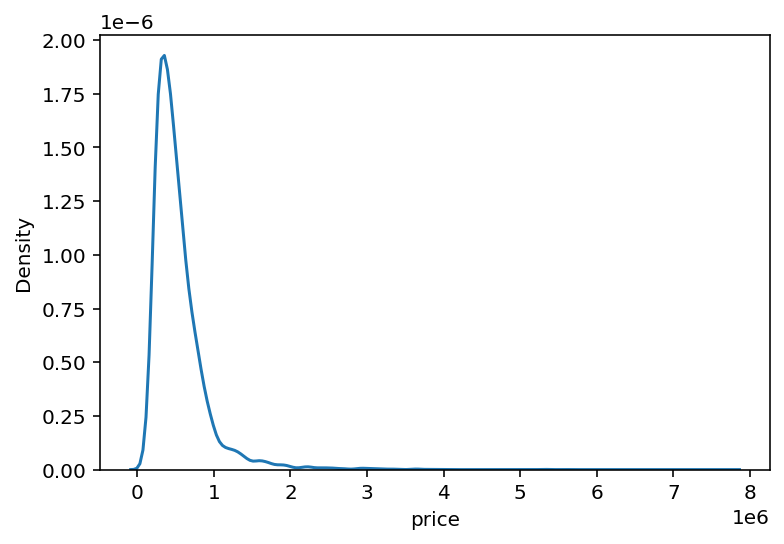

In [22]:
sns.kdeplot(y)
plt.show()

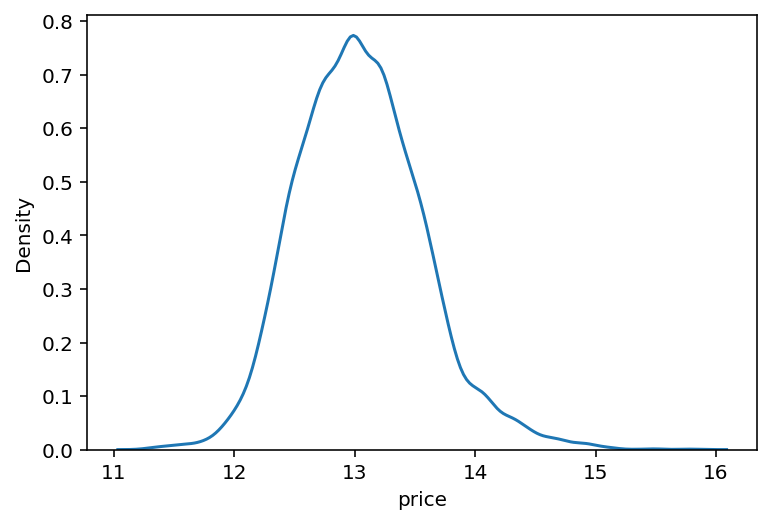

In [23]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [24]:
test['year'] = test['date'].apply(lambda i: i[:4]).astype(int)
test['month'] = test['date'].apply(lambda i: i[4:6]).astype(int)
test.drop(columns=['date'], inplace=True)
test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
1,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
2,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930,2014,5
3,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113,2015,4
4,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570,2015,3


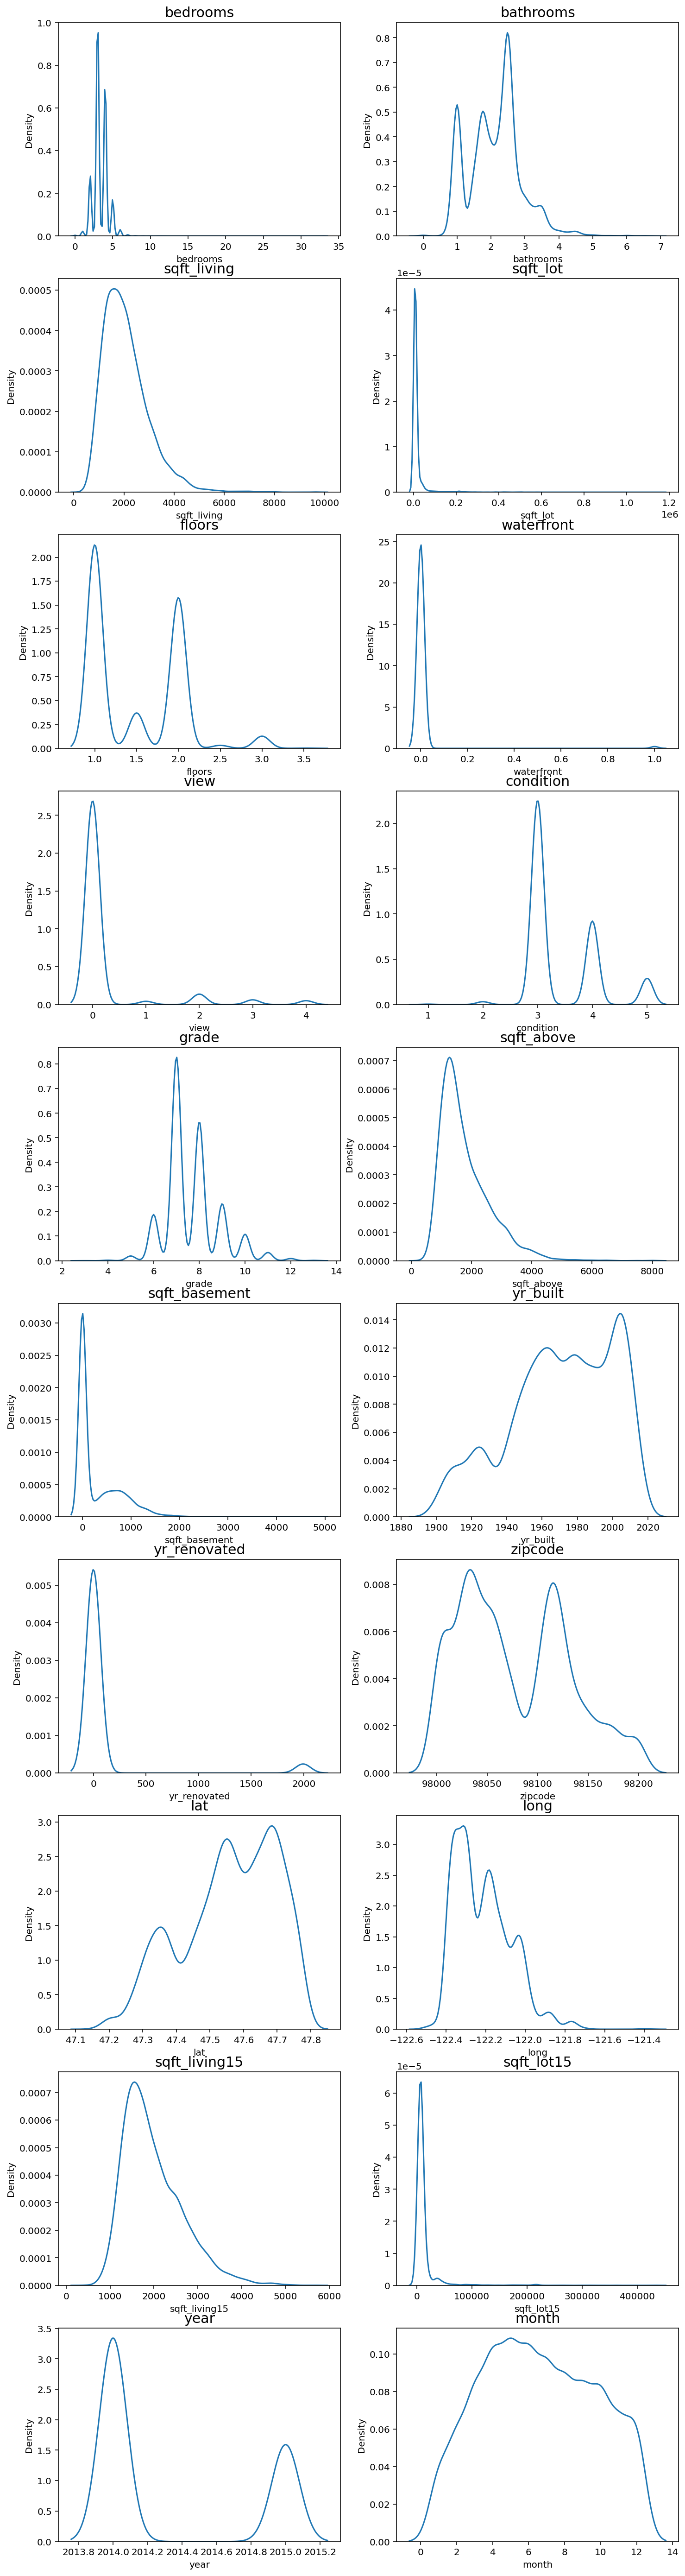

In [25]:
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = test.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=test[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 20 :
            break

In [26]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    test[c] = np.log1p(test[c].values)

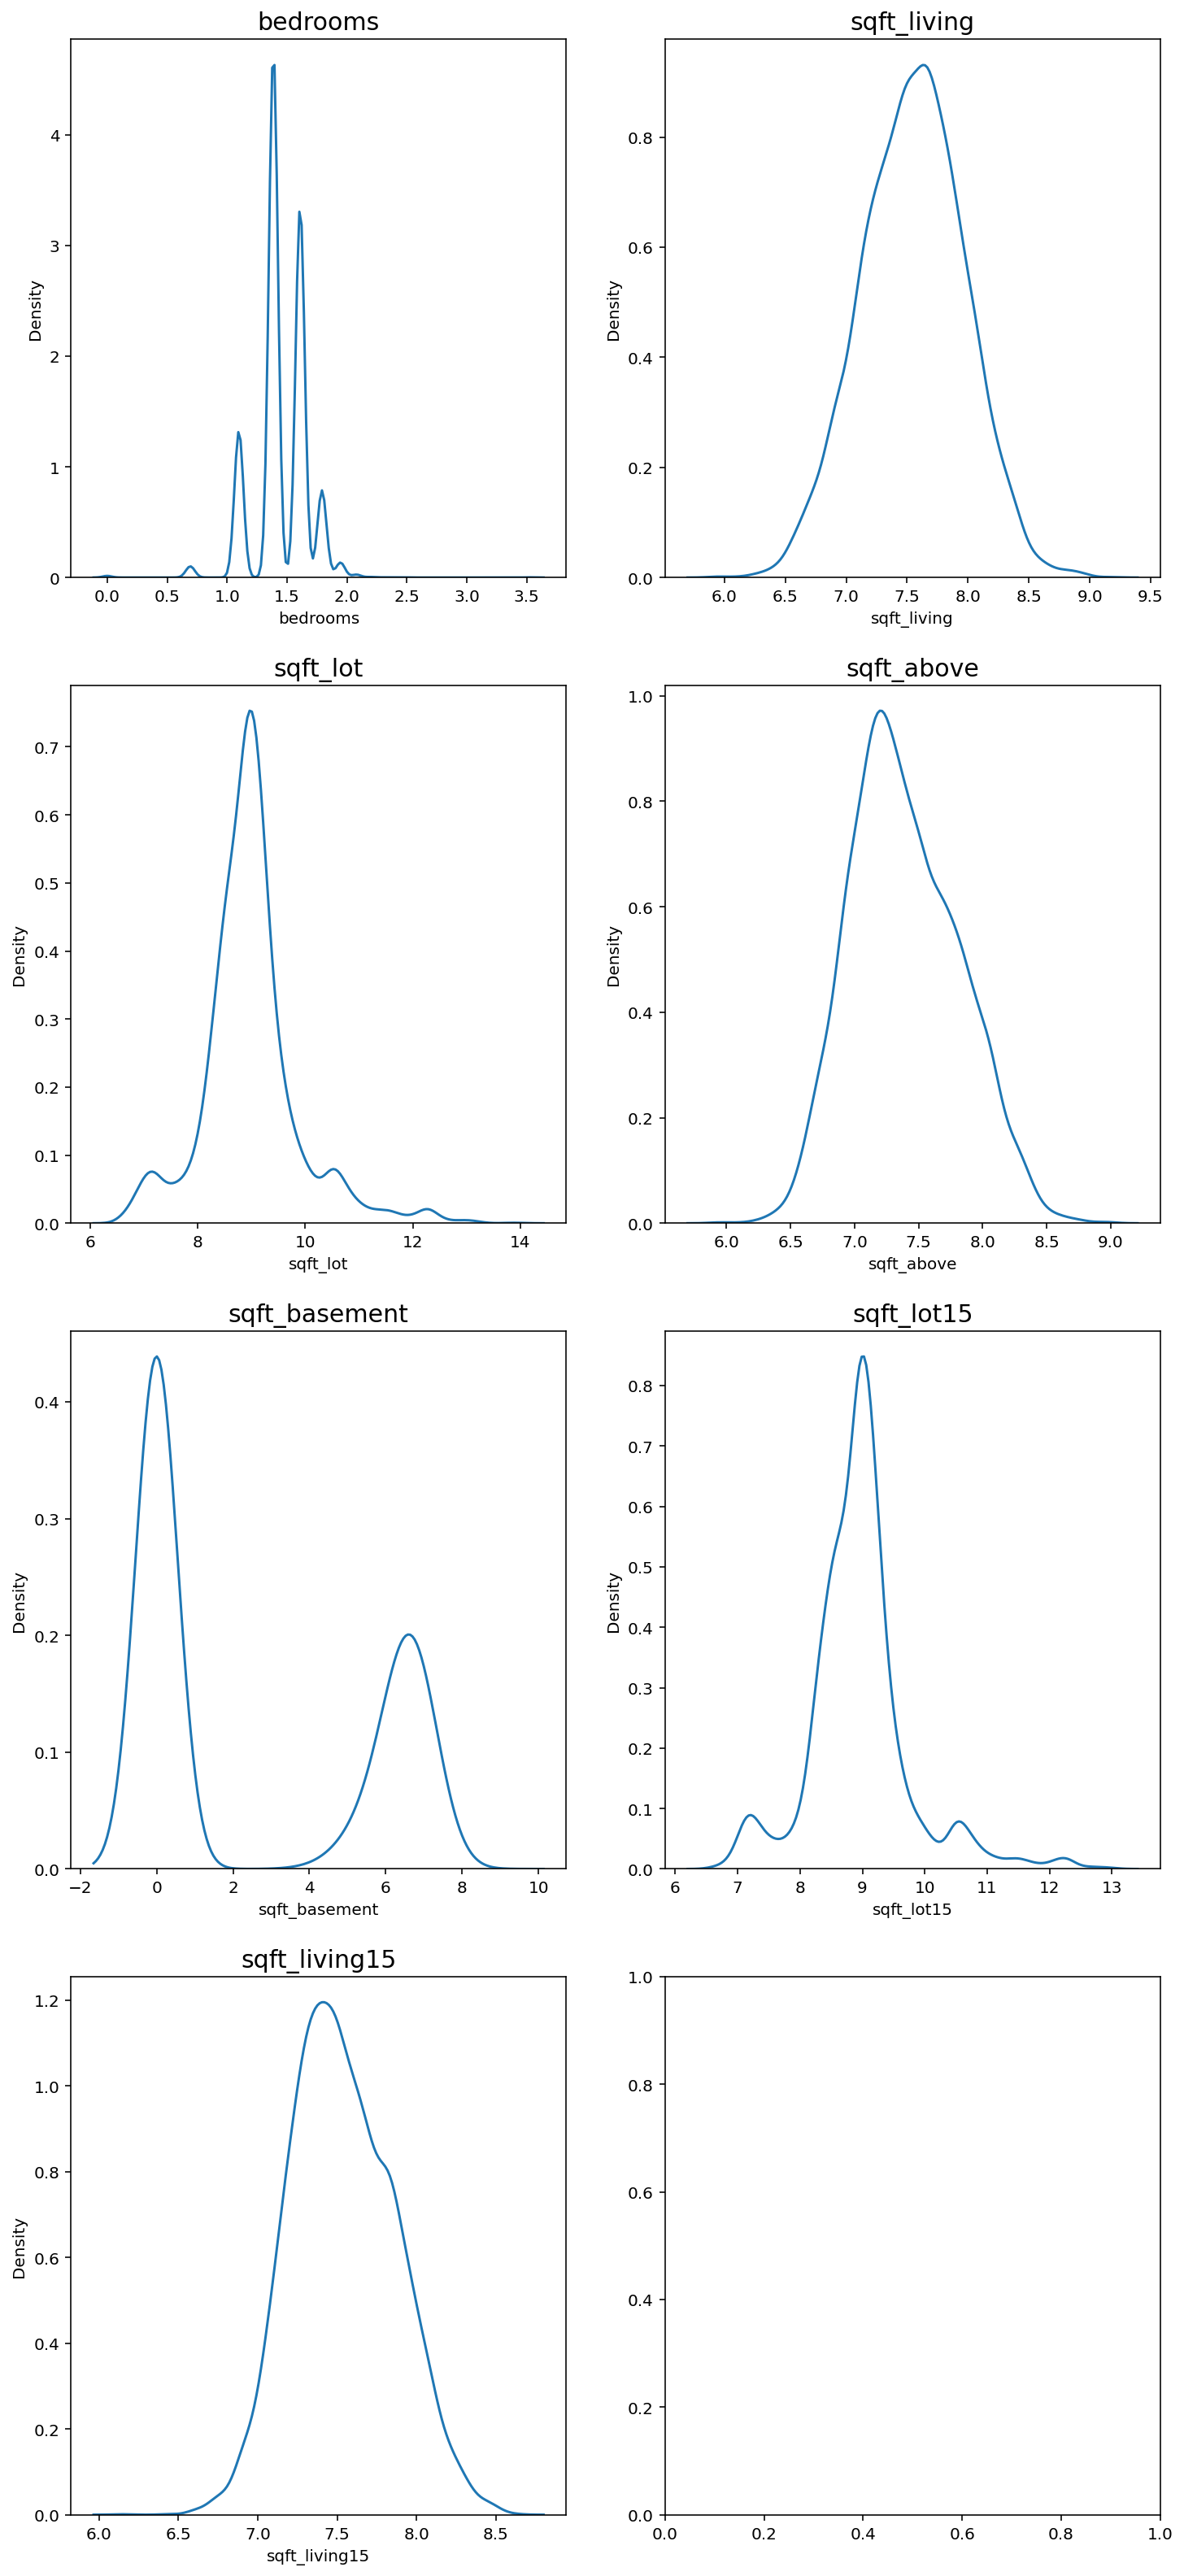

In [27]:
fig, ax = plt.subplots(4, 2, figsize=(12, 28))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=test[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test ) 

        # 예측 결과의 rmse값 저장
        df[model_name] = (mean_squared_error(y_test, y_pred)) ** (1/2)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return df
    


In [29]:

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        


def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [30]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    """

    1. GridSearchCV 모델로 `model`을 초기화합니다.
    2. 모델을 fitting 합니다.
    3. params, score에 각 조합에 대한 결과를 저장합니다. 
    4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.

    usage: `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)`

    """
    
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose=1, n_jobs=5)

    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [31]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [32]:
# e.g.
random_state=2020
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-1.653622e+10,128593.251912
2,10,50,-1.738550e+10,131854.099081
1,1,100,-3.851269e+10,196246.498903
0,1,50,-4.787553e+10,218804.781607


In [46]:
#gboost = GradientBoostingRegressor(random_state=random_state)
#rdforest = RandomForestRegressor(random_state=random_state)
#xgboost = XGBRegressor(random_state=random_state)
#lightgbm = LGBMRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM', 'param':
#               {'n_estimators': [50, 100],
#               'max_depth': [1, 10],}}]


# for model in models:
#     print(model['name'])
#     result = my_GridSearch(model['model'], data, y, param_grid, verbose=2, n_jobs=5)
#     display(result)

In [43]:
display(data)
display(y)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588,2014,10
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041,2015,2
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191,2015,2
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615,2014,6
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,7.832411,8.703507,2014,10
15031,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,7.626083,8.732466,2015,3
15032,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,7.333676,7.319865,2014,5
15033,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,7.512618,8.881975,2015,2


0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [45]:
# xgboost_model = XGBRegressor()
# lgbm_model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
# lgbm_model.fit(data, y)

model = XGBRegressor(random_state=random_state)
model.fit(data, y)
prediction = model.predict(test)

prediction

array([ 546680.25,  553999.  , 1309079.4 , ...,  458280.78,  322937.75,
        456588.  ], dtype=float32)

In [49]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [50]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.466802e+05
1,15036,5.539990e+05
2,15037,1.309079e+06
3,15038,3.573182e+05
4,15039,3.328257e+05


In [51]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'xgboost', '0.--')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

# Private 131357.33850 / Public 121702.65142



/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgboost_RMSLE_0.--.csv


In [48]:
# """
# 아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
# 1. 모델을 `train`, `y`로 학습시킵니다.
# 2. `test`에 대해 예측합니다.
# 3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
# """
# def save_submission(model, train, y, test, model_name, rmsle=None):
#     model.fit(train, y)
#     prediction = model.predict(test)
#     prediction = np.expm1(prediction)
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
#     submission_path = join(data_dir, 'sample_submission.csv')
#     submission = pd.read_csv(submission_path)
#     submission['price'] = prediction
#     submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
#     submission.to_csv(submission_csv_path, index=False)
#     print('{} saved!'.format(submission_csv_path))

# save_submission(model, data, y, test, 'xgboost', rmsle='0.--')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgboost_RMSLE_0.--.csv saved!


(review)
+ Hyperparmeter Grid search 사용시 모델 estimator별로 hyperparameter가 다르므로, 모델 종류별 하이퍼파라미터 dictionary 형태로 입력되도록 한다.
+ gridsearch에서 찾은 하이퍼파라미터로 model을 한 번 더 fit하는 단계가 필요
+ 모델 타겟값을 스케일링하여 학습했을 시에는, 결과값에 스케일링을 역순으로 적용해 주어야 하므로 주의